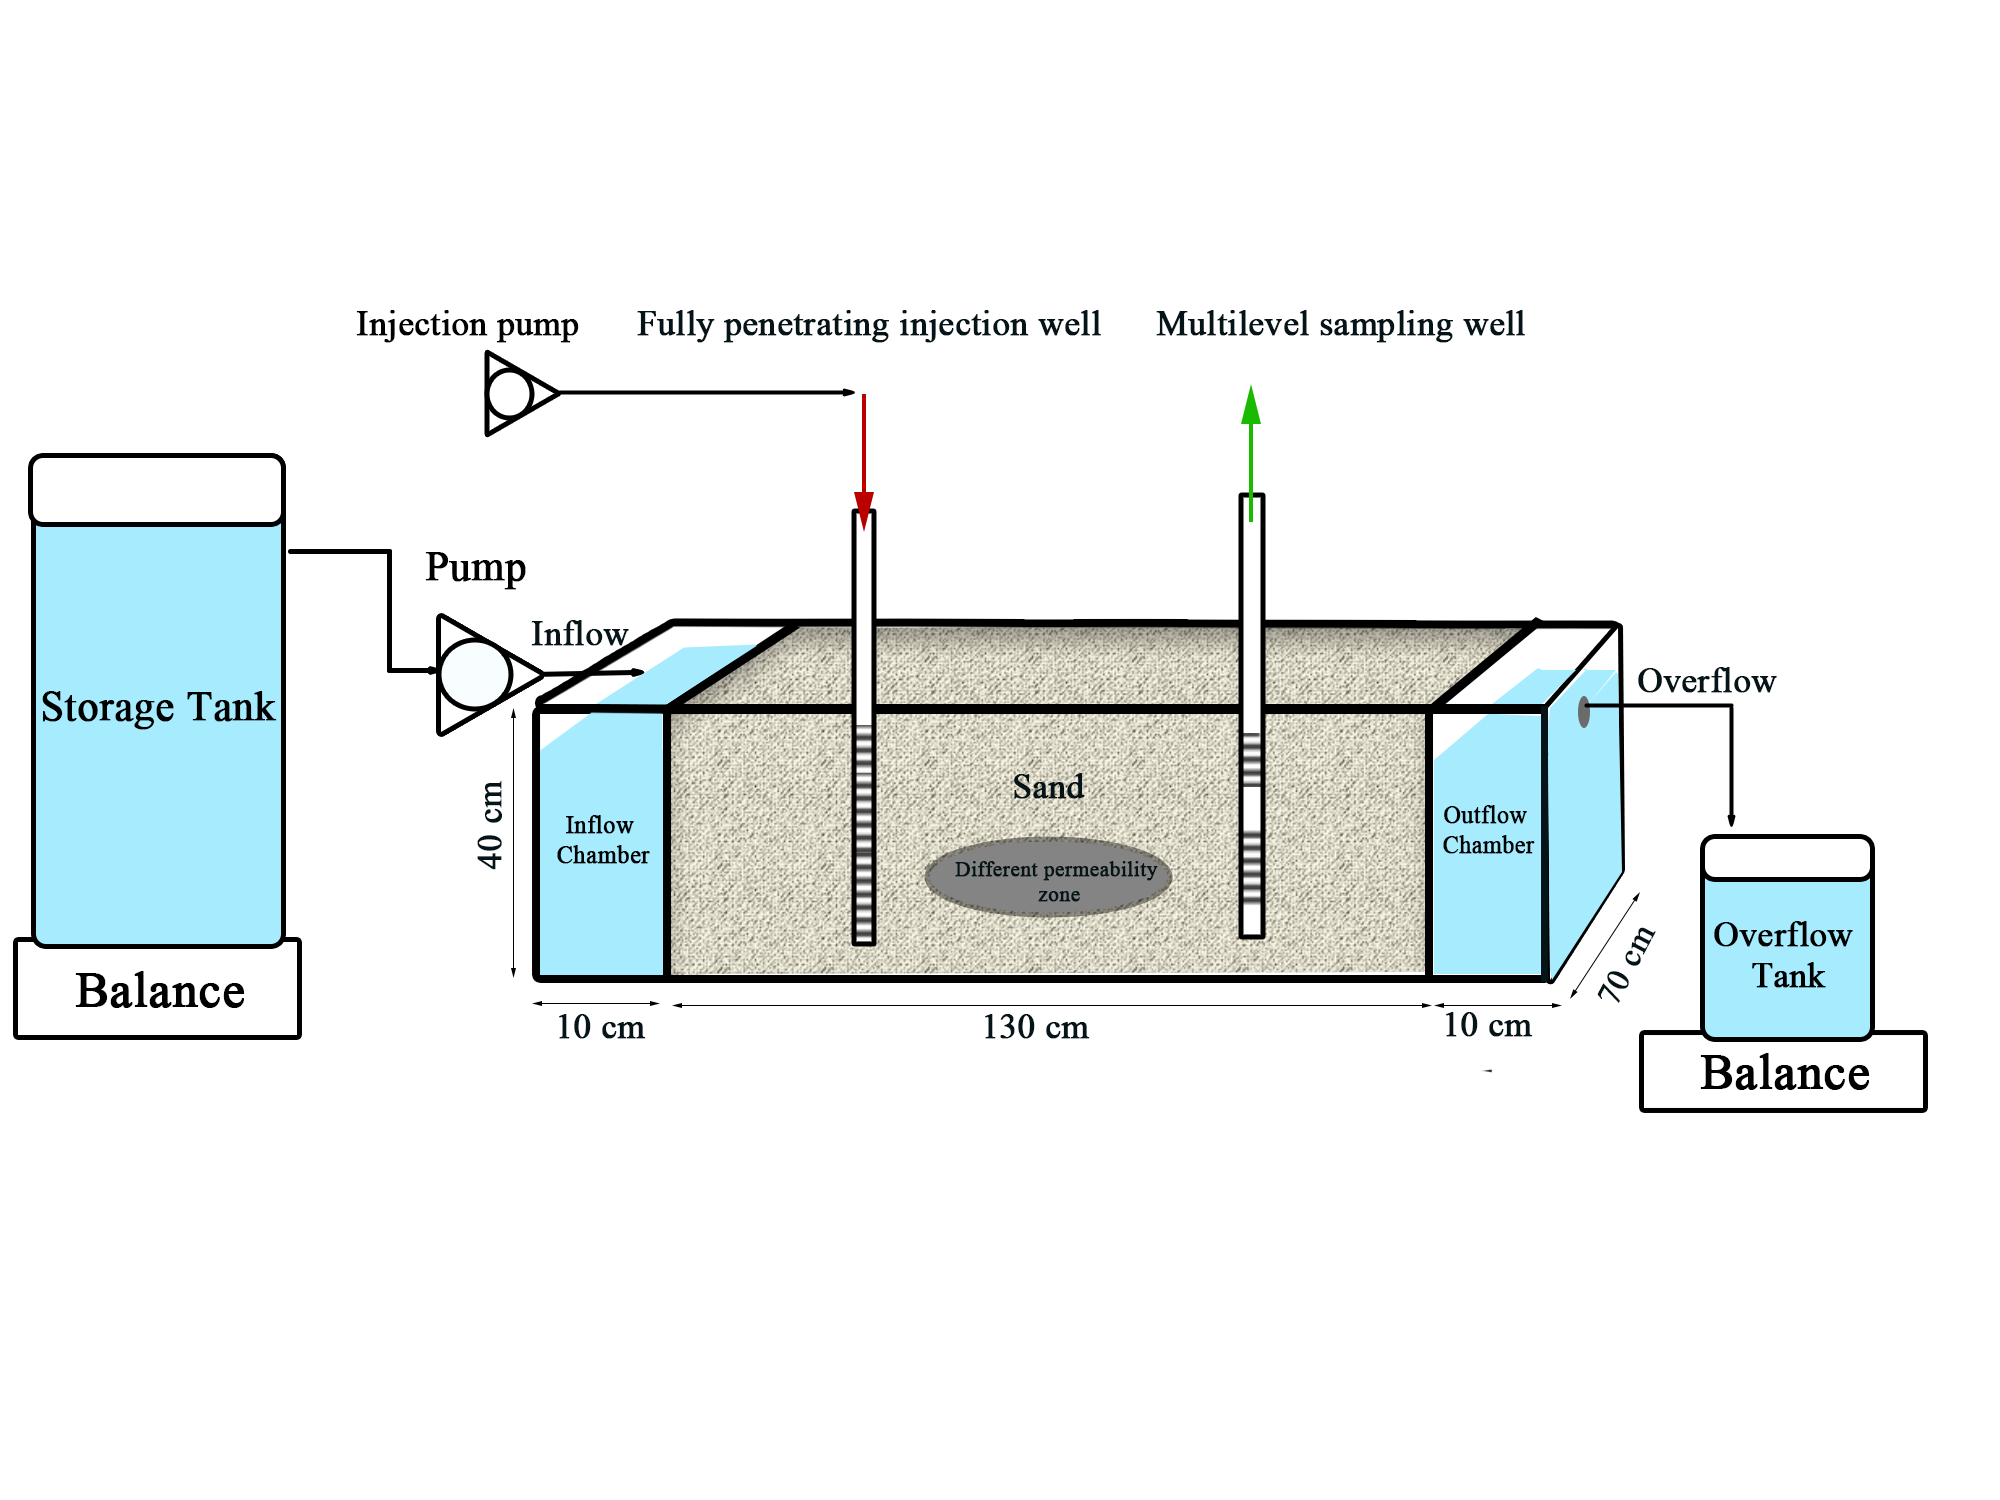




## This notebook* demonstrates how to use the Monte Carlo simulation technique to identify the optimal range of hydraulic parameters for a small sand tank (1.3x0.7m) using observed BTCs (breakthrough curves) for both salt and DNA tracers injected into the tank. 

## To find the optimal hydraulic parameters, the model is run multiple times (thousands), each with different values for the hydraulic parameters chosen within a defined range by the user based on previous knowledge or literature. The simulated BTCs are then evaluated using statistical measures such as R2, RMSE, and other objective functions like time to peak and maximum concentration to determine the optimal range of values for the hydraulic parameters






# Work Flow:


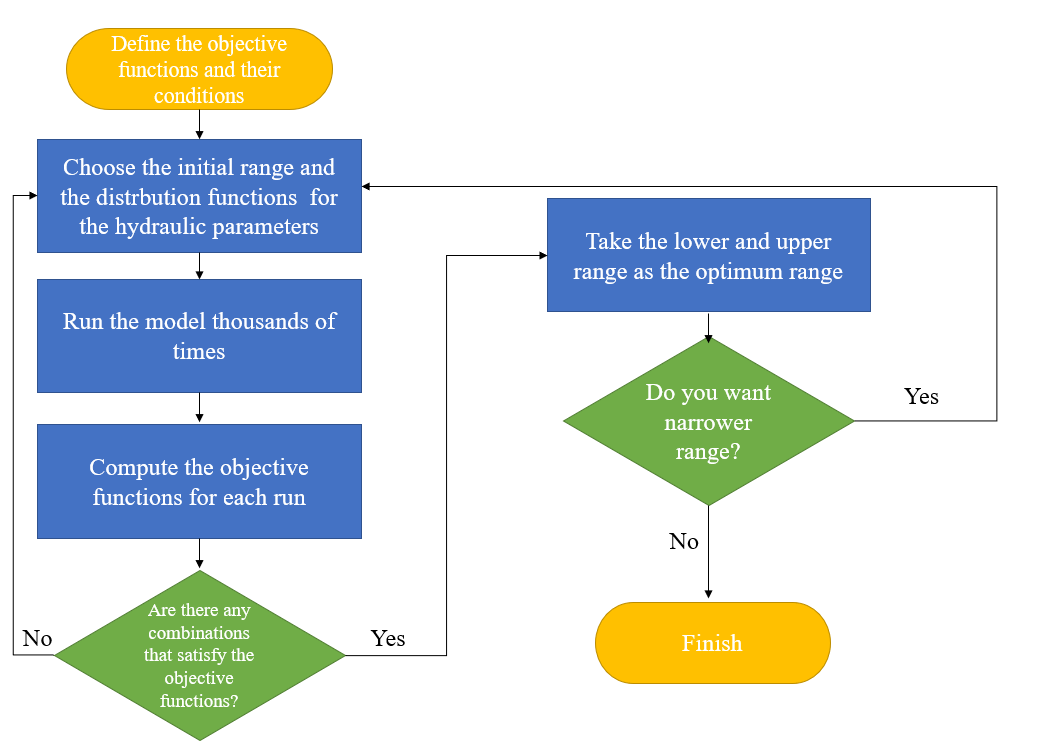

## * Some knoweldge in using Flopy IS NEEDED, check this for more information regarding the Package https://github.com/modflowpy/flopy

# 1.0 Getting Started

## 1.1 Import necessary packages and libraries, we need the following:

In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score,mean_squared_error,mean_absolute_error, r2_score
import os 
os.getcwd()
import time
import flopy
import flopy.utils.binaryfile as bf



## 1.2 Change the location to the directordy that have  mf2005.exe and mt3dms.exe using the 'os' module and the 'chdir()' function


In [ ]:
os.chdir(r'############') 

## 1.3 Assign names and create modflow/mt3dms model object

In [ ]:
modelnamef = 'Flow_Model_Name'
modelnamet = 'Transport_Model_Name'


## 1.4 Link the flow and transport model to the executables to run the model

In [ ]:

m = flopy.modflow.Modflow(modelname=modelnamef, exe_name='mf2005')
mt = flopy.mt3d.Mt3dms(modflowmodel=m, modelname=modelnamet, exe_name='mt3dms' ,ftlfilename='mt3d_link.ftl')

# 2.0 Monet Carlo Simulation

## Prepare the Monte Carlo Simulation using for loop, but before the loop we need to save all the outputs for each run in an excel file so it will be easier to process the data, see the following code:

In [ ]:
with open('Name_of_the_Excel_file.csv', 'w' , newline='') as csvfile:
    fieldnames = ['Hydraulic_Parameter_1','Hydraulic_Parameter_2','etc..','Objective_Function_1','etc..','RMSE','R2']
    thewriter = csv.DictWriter(csvfile,fieldnames=fieldnames)
    thewriter.writeheader()

# 3.0 Prepare the Flow model

In [ ]:
for i in range (#Number of simulations needed):
        
        #Units
        
        length_units = "m"
        time_units = "seconds"
        
        #Model information

        Lx = 1.3
        Ly = 0.7
        ztop = 0.340
        zbot = 0
        nlay = 12 #Number of layers used
        nrow = 70 # Number of rows
        ncol = 130 # Number of columns
        delr = Lx / ncol
        delc = Ly / nrow
        delv = (ztop - zbot) / nlay
        botm = np.linspace(ztop, zbot, nlay+1)
    
        #ibound array
        ibound = np.ones((nlay, nrow, ncol), dtype=int)
        ibound[:, :, 0] = -1
        ibound[:, :, -1] = -1

         #Stress Periods
        itmuni= 1               # 1 for sec 4 for days
        nper = 3                #Number of stress periods
        perlen = [1500,360, 6000]     #An array of the stress period lengths.
        nstp = [10,10, 10]         #Number of time steps in each stress period
        tsmult = [1,1, 1]         #Time step multiplier (default is 1.0).
        steady = [False,False, False] #True = Steady state flow

        #Starting heads
        strt = 0.340* np.ones((nlay, nrow, ncol), dtype=float)
        strt[:, :, 0] = 0.340
        strt[:, :, -1] = 0.300

        
        #Model Parameteres 
         
        #Hydraulic Counductivity
        hk_value=np.random.uniform(#lower_range,#Upper_range) #randomly sample values (uniformly distributed) for the hk within a defined range 
        hk_hetero_value= np.random.uniform(#lower_range,#Upper_range)
        
        #Noww create a dictionary of hK values by zone number (1 = first hk value, 2 = second hk value , 3 ..etc)
        Khvalues = {1:hk_value, 2: hk_hetero_value ,3: hk_hetero_value,4: hk_hetero_value,5: hk_hetero_value,6: hk_hetero_value}
        Kzones = np.ones((nlay,nrow,ncol)) ##Change all the values to ones so it will be changd later to the corresponding value
        Kzones[6:8,54:56,55:58] = 2 # this can be used if heterogeinty needs to be added 
        Kzones[6:8,53:57,58:63] = 3 #for example :layer 7-9, rows 53-59, columns 58-78 have difffernt hydraulic conductivty than all the other cells
        Kzones[6:8,52:58,61:80] = 4
        Kzones[6:8,53:57,78:83] = 5
        Kzones[6:8,54:56,81:86] = 6
                                        
        hk = np.ones((nlay,nrow, ncol), dtype=float) # initialize new array for Khvalues
        for zone, hk_hetero_value in Khvalues.items():hk[Kzones == zone] = hk_hetero_value

        hydraulic_conductivity = hk
            
        #Porosity
        ne_value=np.random.uniform(#lower_range,#upper_range)
        ne_hetero_value=np.random.uniform(#lower_range,#upper_range)
        nevalues = {1:ne_value, 2:ne_hetero_value,3:ne_hetero_value,4:ne_hetero_value,5:ne_hetero_value,6:ne_hetero_value} 
        nezones = np.ones((nlay,nrow,ncol))    
        nezones[6:8,54:56,55:58] = 2 
        nezones[6:8,53:57,58:63] = 3
        nezones[6:8,52:58,61:80] = 4
        nezones[6:8,53:57,78:83] = 5
        nezones[6:8,54:56,81:86] = 6
        ne = np.ones((nlay,nrow, ncol), dtype=float) # initialize new array for Kvalues
        for zone, ne_hetero_value in nevalues.items():ne[nezones == zone] = ne_hetero_value
    
        porosity = ne  


        #Longitudinal dispersivity
        al_value=np.random.uniform(#lower_range,#upper_range)
        al_hetero_value=np.random.uniform(#lower_range,#upper_range)
        alvalues = {1: al_value, 2: al_hetero_value,3:al_hetero_value,
                    4: al_hetero_value,5:al_hetero_value,6:al_hetero_value,} 
        alzones = np.ones((nlay,nrow,ncol))
        alzones[6:8,54:56,55:58] = 2 
        alzones[6:8,53:57,58:63] = 3
        alzones[6:8,52:58,61:80] = 4
        alzones[6:8,53:57,78:83] = 5
        alzones[6:8,54:56,81:86] = 6
        al = np.ones((nlay,nrow, ncol), dtype=float) 
        for zone, al_hetero_value in alvalues.items():al[alzones == zone] = al_hetero_value
    
        Longitudinal_dispersivity = al  
            
        #Other fixed hydraulic parameters
        sy = ne
        ss = 1e-4
        laytyp = [1,0,0,0,0,0,0,0,0,0,0,0]    #first layer unconfied the rest are confied

        # pumping well for transient simulation
            
        wrow=#Location in rows
        wcol=#Location in col

        pumping_rate=#Rate in m3/s
        #Here in stress period 1 and 3 we don't have any pumping happineng so we put zero in the last index
        stress_period_dataw ={0: [
                    [0,wrow,wcol,0],[1,wrow,wcol,0],[2,wrow,wcol,0],
                    [3, wrow, wcol, 0],[4,wrow,wcol,0],[5,wrow,wcol,0],
                    [6, wrow, wcol, 0],[7,wrow,wcol,0],[8,wrow,wcol,0],
                    [9, wrow, wcol, 0],[10,wrow,wcol,0],[11,wrow,wcol,0],  
                    ],
                    1:  [
                                
                    [0, wrow, wcol, pumping_rate],[1,wrow,wcol,pumping_rate],[2,wrow,wcol,pumping_rate],
                    [3, wrow, wcol, pumping_rate],[4,wrow,wcol,pumping_rate],[5,wrow,wcol,pumping_rate],
                    [6, wrow, wcol, pumping_rate],[7,wrow,wcol,pumping_rate],[8,wrow,wcol,pumping_rate],
                    [9, wrow, wcol, pumping_rate],[10,wrow,wcol,pumping_rate],[11,wrow,wcol,pumping_rate]
                    
                    ],
                    2:  [
                    [0,wrow,wcol,0],[1,wrow,wcol,0],[2,wrow,wcol,0],
                    [3, wrow, wcol, 0],[4,wrow,wcol,0],[5,wrow,wcol,0],
                    [6, wrow, wcol, 0],[7,wrow,wcol,0],[8,wrow,wcol,0],
                    [9, wrow, wcol, 0],[10,wrow,wcol,0],[11,wrow,wcol,0],   
                    ]
                             }
            
            
        #MODFLOW Discretization Package Class
        dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, 
        delr=delr, 
        delc=delc,
        top=ztop, 
        botm=botm[1:],
        nper=nper, 
        perlen=perlen, 
        tsmult=tsmult, 
        nstp=nstp, 
        itmuni=itmuni,                               
        steady=steady)

        #MODFLOW Basic Package Class.
        bas = flopy.modflow.ModflowBas(m,ibound=ibound,strt=strt)

        #MODFLOW Output Control Package Class.
        stress_period_data = {}
        for kper in range(nper):
            for kstp in range(nstp[kper]):
                        stress_period_data[(kper, kstp)] = [
                            "save head",
                            "save drawdown",
                            "save budget",
                            "print head",
                            "print budget",
                    ]
        oc = flopy.modflow.ModflowOc(
                    m, stress_period_data=stress_period_data, compact=True
                )

        #MODFLOW Pcg Package Class.
        pcg = flopy.modflow.ModflowPcg(m)


        #MODFLOW Layer Property Flow Package Class.
        lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=hk, sy=sy, ss=ss, laytyp=laytyp,ipakcb=53)

        lmt = flopy.modflow.ModflowLmt(m, output_file_name='mt3d_link.ftl')

        #MODFLOW Well Package Class
        wel = flopy.modflow.ModflowWel(m, stress_period_data=stress_period_dataw)

        # Write the MODFLOW model input files
        m.write_input()

        # Run the MODFLOW model
        success, mfoutput = m.run_model(silent=False, pause=False)

# 4.0 Prepare the Solute Transport model

In [ ]:

        #location of observation well
        ocol = # x index for the obsevation well
        orow = # y index for the obsevation well
        on=#layer at which the observation well extend
        obs_w=[(on,orow,ocol)]

        # basic transport package
        perlen_mt = [1500,360, 6000] #Stress periods for the solute transport model
        btn = flopy.mt3d.Mt3dBtn(mt,prsity=prsityf,icbund = 1,sconc=0.0,ncomp=1,perlen = perlen_mt,nper=3,nstp = 10,
        tsmult = None,
        timprs =[#Times at which the concentration will always be printed (must corrospond with the observed data
            #for example 1860,1980,2100 etc..],
        ]

        nprs = #Number of times in timprs,
        nprobs = 10,
        cinact = 1e30,
        obs=obs_w,
        chkmas=True)

        #advaction package
        adv = flopy.mt3d.Mt3dAdv(
                    mt, 
                    mixelm=0, 
                    percel=0.75)



        #dispersion package
        dsp = flopy.mt3d.Mt3dDsp(
                    mt, 
                    al=al, 
                    trpt=0.1, 
                    trpv=0.1, 
                    dmcoef=0)

        #Chemical reaction package
        rct = flopy.mt3d.Mt3dRct(
        mt,
        isothm=4,
        sp1=sp1r,
        sp2=sp2r,
            )

        #source/sink package #check the **text below for more details how to deal with the source and sink package
        ssm_data = {}
        itype = flopy.mt3d.Mt3dSsm.itype_dict()
        ssm_data[0] = [(0, wrow, wcol, 0, itype['WEL']),(1, wrow, wcol, 0, itype['WEL']),(2, wrow, wcol, 0, itype['WEL']),
                      (3, wrow, wcol, 0, itype['WEL']),(4, wrow, wcol, 0, itype['WEL']),(5, wrow, wcol, 0, itype['WEL']),
                      (6, wrow, wcol, 0, itype['WEL']),(7, wrow, wcol, 0, itype['WEL']),(8, wrow, wcol, 0, itype['WEL']),
                      (9, wrow, wcol, 0, itype['WEL']),(10, wrow, wcol, 0, itype['WEL']),(11, wrow, wcol, 0, itype['WEL']),]
       
        ssm_data[1] = [(0, wrow, wcol, 1, itype['WEL']),(1, wrow, wcol, 1, itype['WEL']),(2, wrow, wcol, 1, itype['WEL']),
                      (3, wrow, wcol, 1, itype['WEL']),(4, wrow, wcol, 1, itype['WEL']),(5, wrow, wcol, 1, itype['WEL']),
                      (6, wrow, wcol, 1, itype['WEL']),(7, wrow, wcol, 1, itype['WEL']),(8, wrow, wcol, 1, itype['WEL']),
                      (9, wrow, wcol, 1, itype['WEL']),(10, wrow, wcol, 1, itype['WEL']),(11, wrow, wcol, 1, itype['WEL']),]
        
        ssm_data[i] = [(0, wrow, wcol, 0, itype['WEL']),(1, wrow, wcol, 0, itype['WEL']),(2, wrow, wcol, 0, itype['WEL']),
                      (3, wrow, wcol, 0, itype['WEL']),(4, wrow, wcol, 0, itype['WEL']),(5, wrow, wcol, 0, itype['WEL']),
                      (6, wrow, wcol, 0, itype['WEL']),(7, wrow, wcol, 0, itype['WEL']),(8, wrow, wcol, 0, itype['WEL']),
                      (9, wrow, wcol, 0, itype['WEL']),(10, wrow, wcol, 0, itype['WEL']),(11, wrow, wcol, 0, itype['WEL']),]


        ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

        #matrix solver package
        gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-4)

        #write mt3dms input
        mt.write_input()
        #run mt3dms
        success, buff = mt.run_model(silent=False)
    

## After running the transport model, concentration file (MT3D001.UCN), an observation file (MT3D001.OBS), a mass balance file (MT3D001.MAS), and a cell-by-cell flow file (modelnamef+'.cbc') will be created which will be used to find the optimal hydraulic parameters


### ** The dictionary ssm_data,  contains information about the sources and sinks for each stress period in the simulation. This dictionary has three keys, corresponding to three stress periods, and each key has a list of lists as its value. Each inner list represents a time step within the stress period and contains five values: the time step number, the row index, the column index, the concentration of the source or sink, and the well type. 
### The row and column indices are defined by the variables wrow and wcol, respectively, and the well type is defined by the itype dictionary. For stress periods 1 and 3, the concentration is set to 0 for all time steps, indicating that there are no active sources or sinks. 
### For stress period 2, the concentration is set to 1 for all time steps, indicating that a source or sink is active at the specified row and column during this stress period.

# _____________________________________________

# 5.0 Finding the optimal hydraulic parameters

### The UcnFile class from the flopy.utils.binaryfile (bf) module [visit (https://flopy.readthedocs.io/en/3.3.2/source/flopy.utils.binaryfile.html)] is used to read in the concentration file. An instance of this class, ucnobj, is created using the MT3D001.UCN file. The get_times method is used to extract the times for which concentration data is available, and the get_alldata method is used to extract all of the concentration data. 

In [ ]:
        ucnobj = bf.UcnFile('MT3D001.UCN')
        times = ucnobj.get_times()
        conc = ucnobj.get_alldata()
        cvt = mt.load_obs('MT3D001.OBS')
        mvt = mt.load_mas('MT3D001.MAS')
        cbb = bf.CellBudgetFile(modelnamef+'.cbc')
        x = cvt["time"]
        y = cvt["on+1,orow+1,ocol+1"]
        
        sim_conc=[]
        for data in (

np.where(x==#the first observation time),
np.where(x==#the second observation time),
np.where(x==#the third ..etc),        
                        
):
        
            sim_conc.append(y[data])
        sim_conc2=[]
        for data2 in range(#number of observed data):
            sim_conc2.append(sim_conc[data2][0])
        obt =[


#The first observation time,
#The second observation time,
#the third observation time,
#etc..
        ]



        obc=[


#The first observed concentration ,
#The second observed concentration,
#the third observed concentration,
#etc..



]
        
        MSE = mean_squared_error(obc,sim_conc2)
        RMSE = np.sqrt(MSE)
        R2= r2_score(obc,sim_conc2)
        if R2 >= 0.9: #Whatever accuracy you want 
            plt.plot(x, y,linewidth=3,label='Kh sand: {:.5f} m/s, ne sand :{:.3f}, Kd : {:.2f} m3/kg , Beta ={:.3} s-1 '.format(
                hydraulic_conductivity, porosity,sp1r,sp2r))
            plt.title("Name of the experiment")
            plt.xlabel("Time (seconds) ")
            plt.ylabel("C/C0")
            
        plt.tight_layout()
            
        max_y = max(y)  # Find the maximum y value = Max C/C0 ~ objective function
        max_x = x[y.argmax()]  # Find the x value corresponding to the maximum y value =  Time To Peak TTP ~  objetive function
        print ('Hydraulic_Parameter_1= {:.5f}, Hydraulic_Parameter_2={:.5f}, etc..={:.5f}, Objective_Function_1={:.5}, 
               'etc..={:.5}, RMSE ={:.5f} , R2={:.5f}'
               .format(hydraulic_conductivity,porosity,dispersivity,etc,RMSE,R2))
        thewriter.writerow({'Hydraulic_Parameter_1' :  hydraulic_conductivity, 'Hydraulic_Parameter_2': porosity, 'etc..' : dispersivity  ,'RMSE' : RMSE,'R2': R2 })

        
colormap = plt.cm.gist_ncar
plt.plot(obt,obc , label='Observed',marker='x',linestyle="None",markersize=15,mew=4,color='red')
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center',prop={"size":25})
plt.savefig("Final_Graph", dpi=300)

## The final plot should show the observed BTC data as points and the simulated BTC data as continuous lines, with each line representing a different combination of hydraulic parameters. The plot can be created using a plotting library like Matplotlib by plotting the observed data as points and the simulated data as lines, and adding labels, a legend, and other desired plot features.

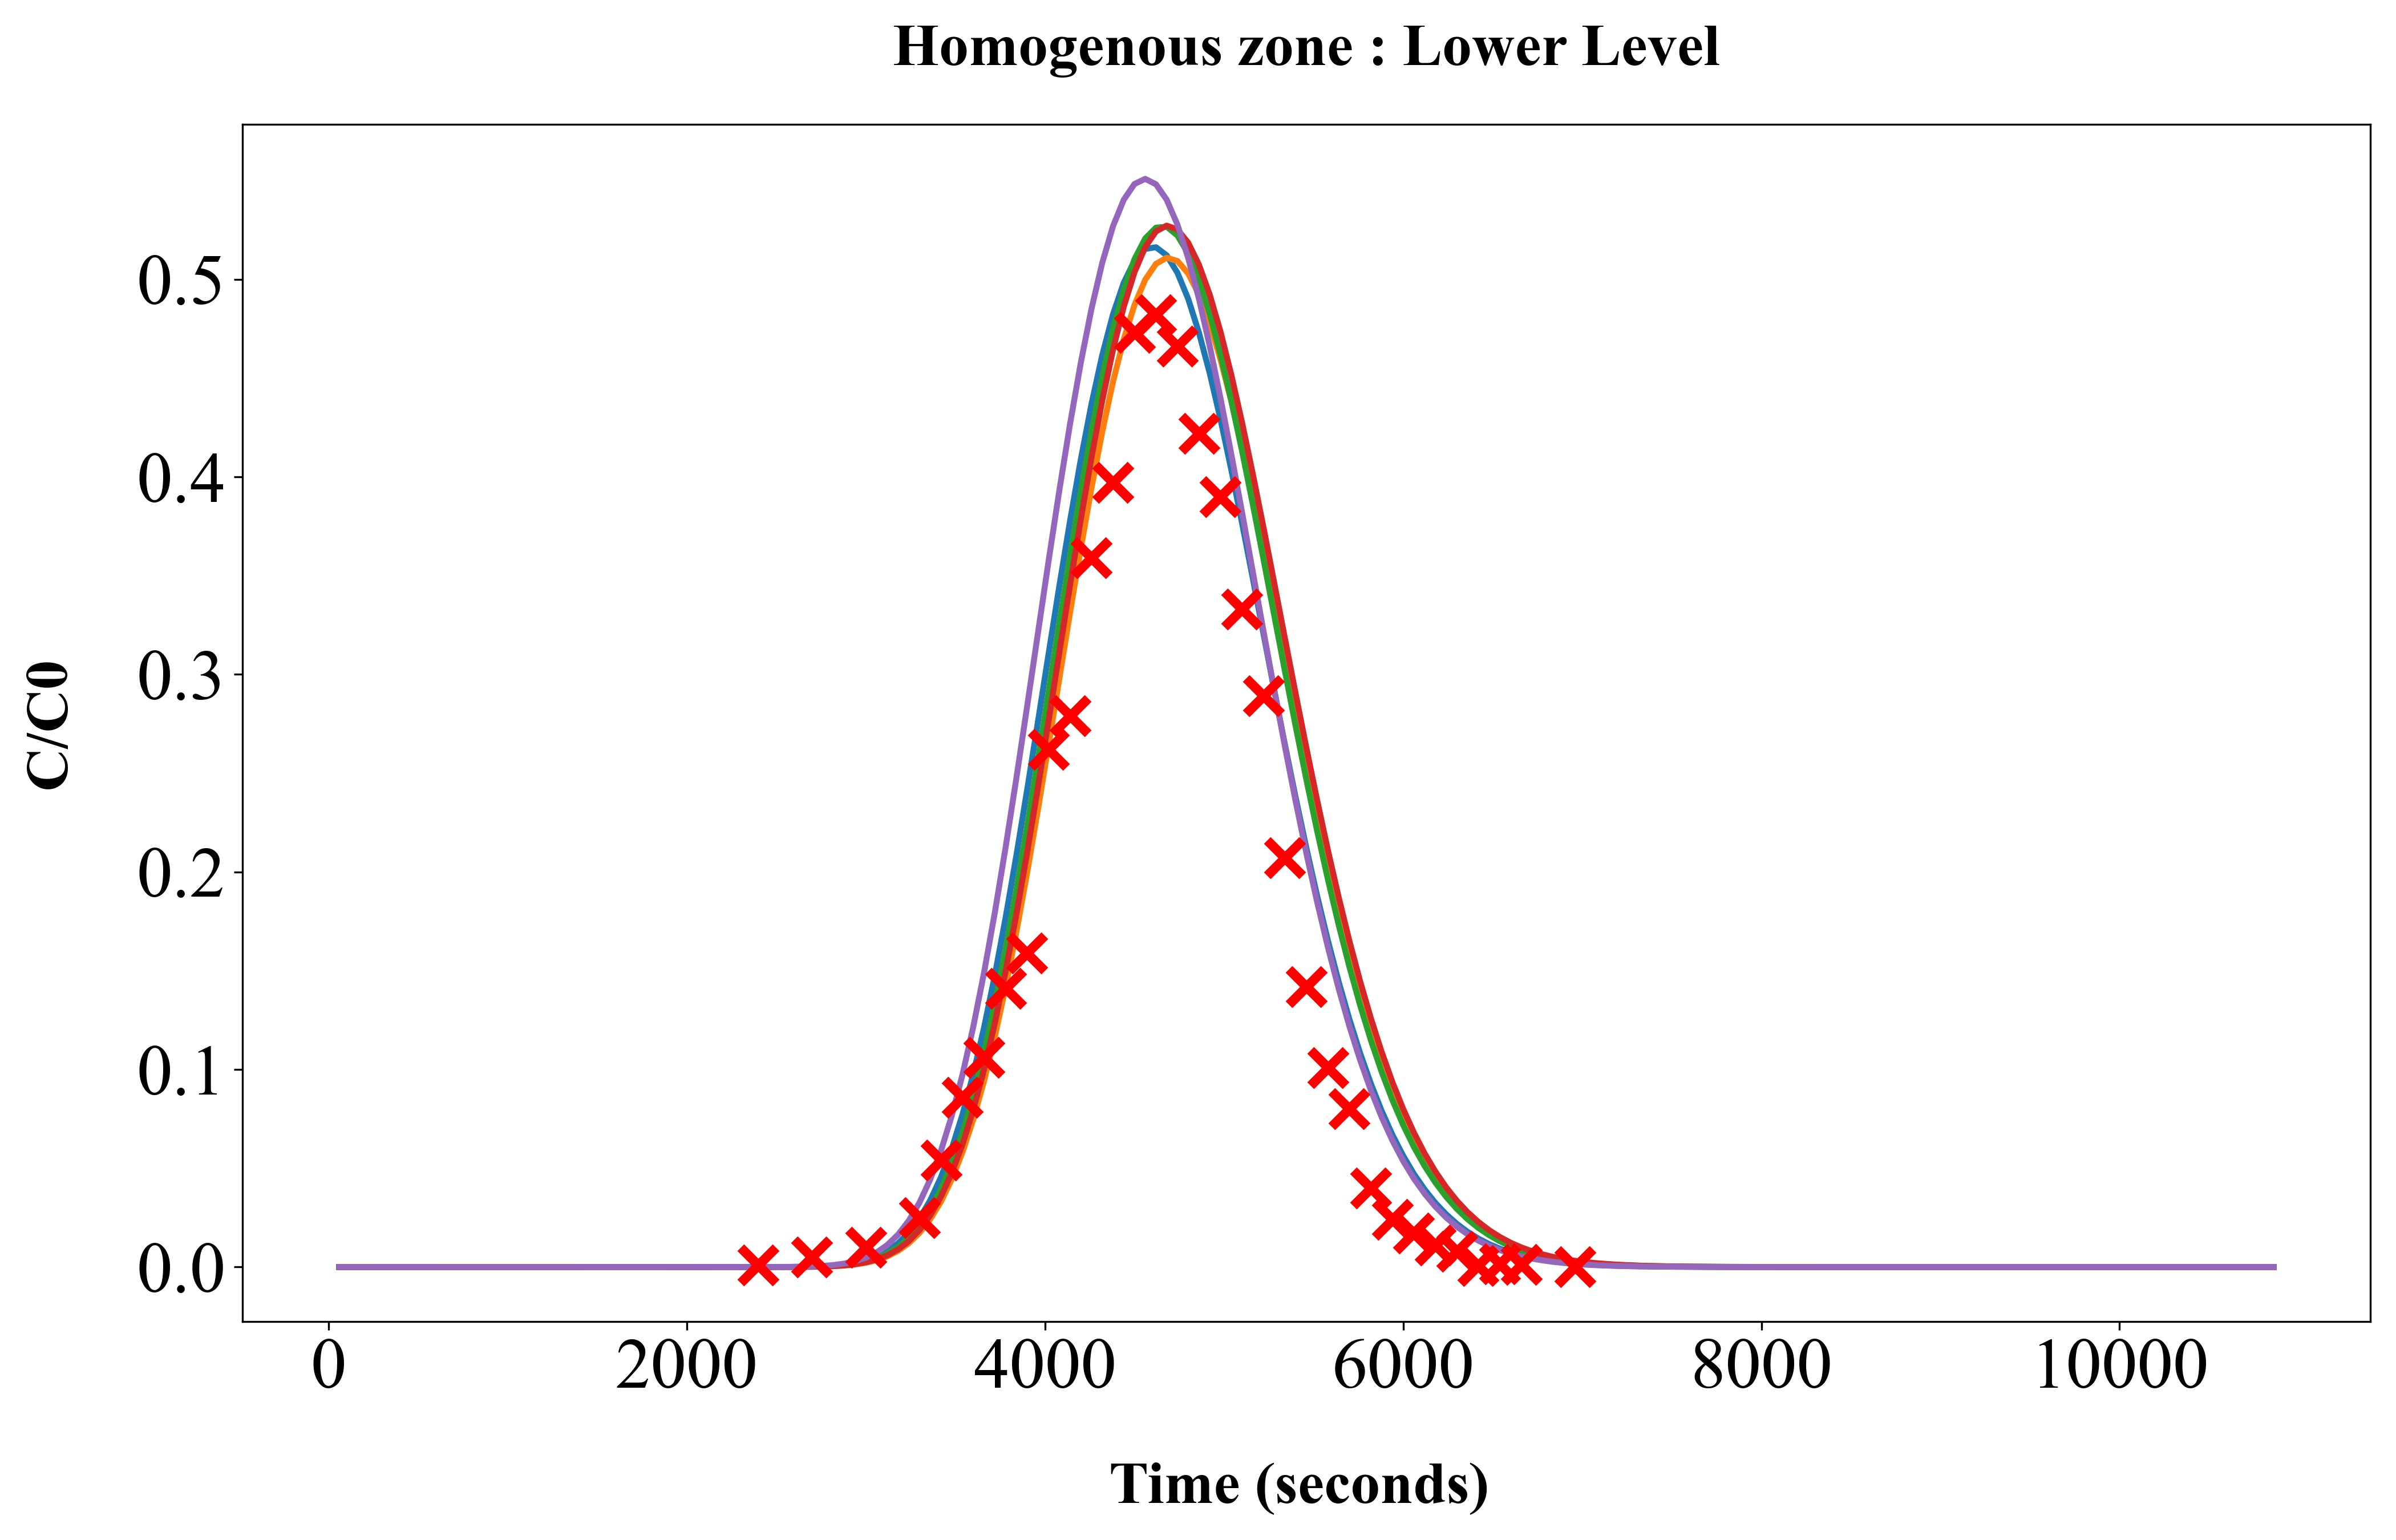


## The Excel sheet will be used to record the values of the hydraulic parameters, along with corresponding values for RMSE and R2. Additional columns, such as TTP (time to peak) and Max C/C0 (maximum concentration over initial concentration), can also be included in the sheet if desired. This sheet can be used to track the results of the Monte Carlo simulation and help identify the optimal range of values for the hydraulic parameters.

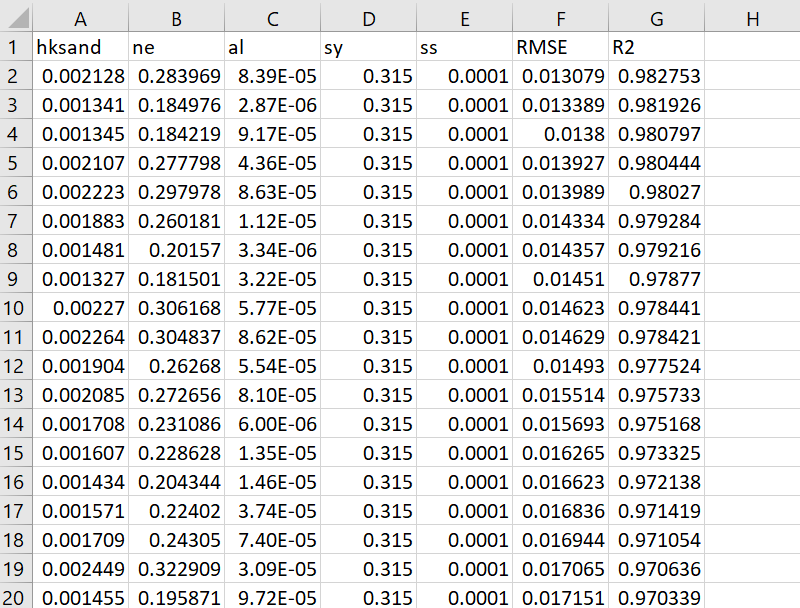